# Deep Learning
### Week 3: Loss functions and backpropagation

## Contents

[1. Introduction](#introduction)

[2. Loss functions](#loss_functions)

[3. Error backpropagation](#backprop)

[4. Automatic differentiation in TensorFlow (\*)](#autodiff)

[5. Dropout](#dropout)

[6. Batch normalisation (\*)](#batchnorm)

[References](#references)

<a class="anchor" id="introduction"></a>
## Introduction

In the last week of the module we took a first look at the prototypical deep learning architecture, which is the multilayer perceptron. You also trained your first deep learning models in TensorFlow, using the Sequential API, and learned the core methods `compile`, `fit`, `evaluate` and `predict`. You saw how the low level objects Tensors and Variables are including in these models to encapsulate mutable parameters and computational operations.

In this week of the course, we will look closer at the issue of training neural networks. We will begin by walking through some commonly used loss functions and the principle of maximum likelihood, and study the important backpropagation algorithm, with a focus on its application to MLP models. We will also look at two commonly used techniques used in deep learning models, which are dropout and batch normalization. 

We will also learn how to implement all of these techniques in TensorFlow, and see how gradients can easily be computed using automatic differentiation tools. 

<a class="anchor" id="loss_functions"></a>
## Loss functions

The loss function is the performance measure which is used to train neural networks. In order to enable gradient-based training, this loss function should be differentiable with respect to the model parameters. 

Given a task and some data, we need a way of formulating a suitable loss function to test our model. The principle that's often used to do this is maximum likelihood.

#### The likelihood function

A probability density function (or probability mass function) $P(y\mid\theta)$ is usually viewed as a function of a sample $y$, with the parameter(s) $\theta$ fixed. In contrast, the likelihood function $\mathcal{L}(\theta \mid y)$ considers $y$ to be fixed and is viewed as a function of $\theta$:

$$\mathcal{L}(\theta\mid y) := P(y\mid\theta).$$

For independent and identically distributed (i.i.d.) samples $y_1,\ldots,y_N$, the probability density/mass function (and likelihood function) decomposes as the product

$$\mathcal{L}(\theta\mid y_1,\ldots,y_N) = P(y_1,\ldots,y_N\mid\theta) = \prod_{i=1}^N P(y_i\mid\theta).$$

An example is the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) with parameter $\theta$. This is the distribution of a random variable that takes value 1 with probability $\theta$ and 0 with probability $1-\theta$. Let $P(y\mid\theta)$ be the probability that the event $y$ occurs given parameter $\theta$. Then

$$
\begin{align}
\mathcal{L}(\theta\mid y) = P(y\mid\theta) &= \begin{cases}
1 - \theta \quad \text{if} \, y = 0 \\
\theta \quad \quad \, \, \, \text{if} \, y = 1 \\
\end{cases} \\
&= (1 - \theta)^{1 - y} \theta^y \quad y \in \{0, 1\}
\end{align}
$$

If we assume samples $y_1,\ldots,y_N$ are i.i.d., we also have
$$
\mathcal{L}(\theta\mid y_1, \ldots, y_N) = \prod_{i=1}^N (1 - \theta)^{1 - y_i} \theta^{y_i}.
$$

Another example is the [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution). This distribution has two parameters: a mean $\mu$ and a standard deviation $\sigma$, so then $\theta = (\mu, \sigma)$. The probability density function is:

$$
\mathcal{L}(\theta\mid y) = P(y | \theta) = P(y | \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \Big( - \frac{1}{2 \sigma^2} (y - \mu)^2 \Big).
$$

For a sequence of i.i.d. observations $y_1, \ldots, y_N$, the likelihood is 

$$
\mathcal{L}(\mu, \sigma\mid y_1, \ldots, y_N) = \prod_{i=1}^N \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \Big( - \frac{1}{2 \sigma^2} (y_i - \mu)^2 \Big).
$$

#### Maximum likelihood estimation

The likelihood function is commonly used in statistical inference when we are trying to fit a distribution to some data. Suppose we have observed data $y_1, \ldots, y_N$, assumed to be from some distribution with unknown parameter $\theta$, which we want to estimate. The likelihood is

$$
\mathcal{L}(\theta\mid y_1, \ldots, y_N).
$$

The *maximum likelihood estimate* $\theta_{\text{MLE}}$ of the parameter $\theta$ is then the value that maximises the likelihood $\mathcal{L}(\theta\mid y_1, \ldots, y_N)$. 

Recall that, for i.i.d. observations, the likelihood becomes a product:

$$
\mathcal{L}(\theta\mid y_1, \ldots, y_N) = \prod_{i=1}^N P(y_i | \theta).
$$

Furthermore, since the $\log$ function is a strictly concave function, maximising the likelihood is equivalent to maximising the log-likelihood $\log \mathcal{L}(\theta\mid y_1, \ldots, y_N)$. This changes the product into a sum:

$$
\begin{align}
\theta_{\text{MLE}} &= \arg \max_{\theta} \mathcal{L}(\theta\mid y_1, \ldots, y_N) \\
&= \arg \max_{\theta} \log \mathcal{L}(\theta\mid y_1, \ldots, y_N) \\
&= \arg \max_{\theta} \log \prod_{i=1}^N \mathcal{L}(\theta\mid y_i) \\
&= \arg \max_{\theta} \sum_{i=1}^N \log \mathcal{L}(\theta\mid y_i).
\end{align}
$$

Conventionally, we usually choose to instead equivalently *minimise* the *negative log-likelihood*:

$$
\theta_{\text{MLE}} = \arg \min_{\theta} \left( - \sum_{i=1}^N \log \mathcal{L}(\theta\mid y_i) \right).$$

#### Training neural networks

We can use the principle of maximum likelihood to formulate loss functions that are used to train neural networks. Given some training data $\mathcal{D} := (x_i, y_i)_{i=1}^N$ of inputs $x_i$ and outputs $y_i$, we search for the weights of the neural network that minimise the negative log-likelihood of the data. 

For example, suppose we would like to train a neural network binary classifier. Then we have $y_i\in\{0, 1\}$. Denote the neural network model as $f_\theta:\mathbb{R}^D\mapsto [0, 1]$, where $\theta$ are the parameters of the network. We can constrain the range of the network by using a sigmoid activation function on a single output neuron. Then we can interpret the output of the network as the probability that a given input $x_i$ has output $y_i = 1$:

$$f_\theta(x_i) = P_\theta(y_i=1\mid x_i).$$

Therefore the network output is parameterising a Bernoulli distribution. The negative log-likelihood can be written

$$
\begin{align}
-\log \mathcal{L}(\theta\mid\mathcal{D}) &= -\sum_{i=1}^N \log \mathcal{L}(\theta \mid y_i, x_i) \\
&= -\sum_{i=1}^N \log\left\{ (1 - f_\theta(x_i))^{(1 - y_i)} f_\theta(x_i)^{y_i} \right\} \\
&= -\sum_{i=1}^N \left\{(1 - y_i) \log (1 - f_\theta(x_i)) + y_i \log f_\theta(x_i) \right\},
\end{align}
$$

and we have derived the binary cross entropy loss function to be minimised. 

As another example, suppose we would like to train a network as a regression function, so that $y_i\in\mathbb{R}$. Again denote  the neural network model as $f_\theta:\mathbb{R}^D\mapsto \mathbb{R}$, where $\theta$ are the parameters of the network. This time, we can use no activation function on the output neuron of the network. 

We can additionally define our model such that the network $f_\theta(x_i)$ parameterises the mean of a normal distribution, so that

$$
y_i \sim N(f_\theta(x_i), \sigma^2)
$$

for some fixed $\sigma^2 > 0$. In this case, the negative log-likelihood can be written

$$
\begin{align}
-\log \mathcal{L}(\theta\mid\mathcal{D}) &= -\sum_{i=1}^N \log \mathcal{L}(\theta \mid y_i, x_i) \\
&= -\sum_{i=1}^N \log\left\{ \frac{1}{\sigma\sqrt{2\pi}}\exp\left( -\frac{1}{2\sigma^2}(f_\theta(x_i) - y_i)^2 \right) \right\} \\
&= \sum_{i=1}^N \frac{1}{2\sigma^2} (f_\theta(x_i) - y_i)^2 + \log(\sigma\sqrt{2\pi}).
\end{align}
$$

The term $\log(\sigma\sqrt{2\pi})$ does not depend on the parameters $\theta$ that are to be optimised, and so can be ignored for the purpose of finding $\theta_\text{MLE}$. Then we have derived the mean squared error loss, up to a scaling factor (which also does not affect $\theta_{\text{MLE}}$ as the minimizer).

Note that importantly, these loss functions are differentiable with respect to the parameters $\theta$, so long as the network function $f_\theta$ itself is differentiable. This is important to allow the use of gradient-based optimizers.

<a class="anchor" id="backprop"></a>
## Error backpropagation

Gradient-based neural network optimisation can be seen as iterating over the following two main steps:

1. Computation of the (stochastic) gradient of the loss function with respect to the model parameters
2. Use of the computed gradient to update the parameters

We have already seen the parameter update rule according to stochastic gradient descent for a neural network model $f_\theta:\mathbb{R}^D\mapsto Y$, where $Y$ is the target space (e.g. $\mathbb{R}^{n_{L+1}}$ or $[0, 1]^{n_{L+1}}$):

$$
\theta_{t+1} = \theta_{t} - \eta \nabla_t L(\theta_t; \mathcal{D}_m),\qquad t\in\mathbb{N}_0. \tag{1}
$$

In the above equation, the minibatch loss $L(\theta_t; \mathcal{D}_m)$ is calculated on a randomly drawn sample of data points from the training set,

$$
L(\theta_t; \mathcal{D}_m) = \frac{1}{M} \sum_{x_i, y_i\in\mathcal{D}_m} l(y_i, f_{\theta_t}(x_i)). \tag{2}
$$

where $\mathcal{D}_m$ is the randomly sampled minibatch, $M = |\mathcal{D}_m| \ll |\mathcal{D}_{train}|$ is the size of the minibatch, and we will denote $L_i:Y\times Y\mapsto \mathbb{R}$, given by $L_i := l(y_i, f_\theta(x_i))$, as the per-example loss. 

The update \eqref{sgd} requires computation of the term $\nabla_t L(\theta_t; \mathcal{D}_m)$ (from here we drop the $\mathcal{D}_m$ in this expresesion for brevity); that is, the gradient of the loss function with respect to all of the model parameters, evaluated at the current parameter settings $\theta_t$.

The computation of the derivatives is done through applying the chain rule of differentiation. The algorithm for computing these derivatives in an efficient manner is known as **backpropagation**, and was popularised for use in neural network optimisation in [Rumelhart et al 1986b](#Rumelhart86b) and [Rumelhart et al 1986c](#Rumelhart86c), although the technique dates back earlier, see e.g. [Werbos](#Werbos94) which includes Paul Werbos' 1974 dissertation.

In this section, we will derive the important backpropagation algorithm for finding the loss function derivatives for a multilayer perceptron.

First recall the layer transformations in the MLP:


$$
\begin{align}
\mathbf{h}^{(0)} &:= \mathbf{x}, \tag{3}\\
\mathbf{h}^{(k)} &= \sigma\left( \mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)} \right),\qquad k=1,\ldots, L,\tag{4}\\
\hat{\mathbf{y}} &= \sigma_{out}\left( \mathbf{w}^{(L)}\mathbf{h}^{(L)} + b^{(L)} \right), \tag{5}
\end{align}
$$

where $\mathbf{W}^{(k)}\in\mathbb{R}^{n_{k+1}\times n_k}$, $\mathbf{b}^{(k)}\in\mathbb{R}^{n_{k+1}}$, $\mathbf{h}^{(k)}\in\mathbb{R}^{n_k}$, $\hat{\mathbf{y}}\in Y$, $\sigma, \sigma_{out}:\mathbb{R}\mapsto\mathbb{R}$ are activation functions that are applied element-wise, $n_0 := D$, and $n_k$ is the number of units in the $k$-th hidden layer. 

Also recall that we define the **pre-activations**

$$
\mathbf{a}^{(k)} = \mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)} \tag{6}
$$

and **post-activations**

$$
\mathbf{h}^{(k)} = \sigma(\mathbf{a}^{(k)}). \tag{7}
$$

We will consider the gradient of the loss computed on a single data example $\nabla_t {L}_i(\theta_t)$, given the sum \eqref{minibatch_loss}. We first compute the **forward pass** \eqref{fp1}-\eqref{fp3} and store the preactivations $\mathbf{a}^{(k)}$ and post-activations $\mathbf{h}^{(k)}$.

<img src="figures/forward.png" alt="Forward pass" style="width: 800px;"/>
<center>Pre-activations, post-activations, weights and biases in the forward pass</center>

Consider the derivative of $L_i$ with respect to $w^{(k)}_{pq}$ and $b^{(k)}_p$. We have:

$$
\begin{align}
\frac{\partial L_i}{\partial w^{(k)}_{pq}} &= \frac{\partial L_i}{\partial a^{(k+1)}_p} \frac{\partial a^{(k+1)}_p}{\partial w^{(k)}_{pq}} \\
&= \frac{\partial L_i}{\partial a^{(k+1)}_p} h^{(k)}_q,
\end{align}
$$

where the second line follows from \eqref{preactivations}. Similarly,

$$
\begin{align}
\frac{\partial L_i}{\partial b^{(k)}_{p}} &= \frac{\partial L_i}{\partial a^{(k+1)}_p} \frac{\partial a^{(k+1)}_p}{\partial b^{(k)}_{p}} \\
&= \frac{\partial L_i}{\partial a^{(k+1)}_p}. 
\end{align}
$$

We introduce the notation $\delta^{(k)}_p := \frac{\partial L_i}{\partial a^{(k)}_p}$, called the **error**. We then write

$$
\begin{align}
\frac{\partial L_i}{\partial w^{(k)}_{pq}} &= \delta^{(k+1)}_p h^{(k)}_q \tag{8}\\
\frac{\partial L_i}{\partial b^{(k)}_{p}} &= \delta^{(k+1)}_p. \tag{9}
\end{align}
$$

We therefore need to compute the quantity $\delta^{(k+1)}_p$ for each hidden and output unit in the network. Again using the chain rule, we have

$$
\begin{align}
\delta^{(k)}_p \equiv \frac{\partial L_i}{\partial a^{(k)}_p} &= \sum_{j=1}^{n_{k+1}} \frac{\partial L_i}{\partial a^{(k+1)}_j} \frac{\partial a^{(k+1)}_j}{\partial a^{(k)}_p} \\
&= \sum_{j=1}^{n_{k+1}} \delta^{(k+1)}_j \frac{\partial a^{(k+1)}_j}{\partial a^{(k)}_p} \tag{10}
\end{align}
$$

Combining \eqref{preactivations} and \eqref{activations} we see that

$$
\begin{align}
a^{(k+1)}_j &= \sum_{l=1}^{n_k} w^{(k)}_{jl} \sigma(a^{(k)}_l) + b^{(k)}_p \tag{11}\\
\frac{\partial a^{(k+1)}_j}{\partial a^{(k)}_p} &= w^{(k)}_{jp} \sigma'(a^{(k)}_p)
\end{align}
$$

where $\sigma'$ is the derivative of the activation function. So from the above equation and \eqref{recursive_error} we have

$$
\begin{align}
\delta^{(k)}_p \equiv \frac{\partial L_i}{\partial a^{(k)}_p} &= \sum_{j=1}^{n_{k+1}} \delta^{(k+1)}_p \frac{\partial a^{(k+1)}_j}{\partial a^{(k)}_p}\\
&=  \sigma'(a^{(k)}_p) \sum_{j=1}^{n_{k+1}} w^{(k)}_{jp}  \delta^{(k+1)}_j \tag{12}
\end{align}
$$

Equation \eqref{error_backprop} is analogous to \eqref{activation_forward}, and describes the backpropagation of errors through the network. We can write it in the more concise form (analogous to \eqref{activations}):

$$
\mathbf{\delta}^{(k)} = \mathbf{\sigma}'(\mathbf{a}^{(k)})(\mathbf{W}^{(k)})^T \mathbf{\delta}^{(k+1)},
$$

where $\mathbf{\sigma}'(\mathbf{a}^{(k)}) = \text{diag} ([\mathbf{\sigma}'(a^{(k)}_p)]_{p=1}^{n_k})$.

<img src="figures/forward_backward_pass.png" alt="Forward and backward passes" style="width: 650px;"/>
<center>Forward and backward passes</center>

Now we can summarise the backpropagation algorithm as follows:

>1. Propagate the signal forwards by passing an input vector $x_i$ through the network and computing all pre-activations and post-activations using $\mathbf{a}^{(k)} = \mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)}$
> 2. Evaluate $\mathbf{\delta}^{(L+1)} = \frac{\partial L_i}{\partial \mathbf{a}^{(L+1)}}$ for the output neurons
> 3. Backpropagate the errors to compute $\mathbf{\delta}^{(k)}$ for each hidden unit using $\mathbf{\delta}^{(k)} = \mathbf{\sigma}'(\mathbf{a}^{(k)})(\mathbf{W}^{(k)})^T \mathbf{\delta}^{(k+1)}$
> 4. Obtain the derivatives of $L_i$ with respect to the weights and biases using $\frac{\partial L_i}{\partial w^{(k)}_{pq}} = \delta^{(k+1)}_p h^{(k)}_q,\quad 
\frac{\partial L_i}{\partial b^{(k)}_{p}} = \delta^{(k+1)}_p$

The backpropagation algorithm can easily be extended to apply to any directed acyclic graph, but we have presented it here in the case of MLPs for simplicity.

<a class="anchor" id="autodiff"></a>
## Automatic differentiation in TensorFlow

One of the major advantages of using deep learning frameworks like TensorFlow is the ability to automatically compute gradients of any differentiable operation. When using the Keras `model.fit` API, TensorFlow applies the backpropagation equations automatically to compute gradients, and then uses the optimiser algorithm selected to update the parameters.

In this section, we will see how lower-level tools in TensorFlow can be leveraged to compute gradients of differentiable expressions, and build a custom training loop that breaks down the training loop to give you extra flexibility when you need it.

In [55]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Operations that you want to take gradients with respect to need to be defined inside a `tf.GradientTape` context:

In [19]:
# Define a simple operation and take the gradient
x = tf.constant(3.)

with tf.GradientTape() as tape:
    #track any operations that involve x
    tape.watch(x)
    y = 4*tf.square(x) - x
dydx = tape.gradient(y,x)
dydx


<tf.Tensor: shape=(), dtype=float32, numpy=23.0>

In [20]:
# Take multiple derivatives
x = tf.constant([[1.5,2],[0,1.1]])
y = tf.constant([-1,0.5])

with tf.GradientTape() as tape:
    tape.watch([x,y])
    a = tf.constant([0.3,2.5])
    #square elements of x and average over row
    z = tf.reduce_mean(x**2, axis = 0) * a + y
tape.gradient(z,[x,y])
#the derivative with respect to x should be 2x2 since x is 2x2



[<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.45000002, 5.        ],
        [0.        , 2.75      ]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>]

In [21]:
# Gradients can also be computed with respect to intermediate variables
x = tf.random.normal((2,3))

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.math.sin(x) # 2 x 3 tensor
    a = tf.random.normal((3,2)) # 3 x 2 tensor
    z = tf.reduce_mean(tf.linalg.matmul(y,a))
#again we expect the derivatives to be the same shape as the original data
dzdx, dzdy = tape.gradient(z,[x,y])
    

In [22]:
# Gradients can be taken once by default
with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.math.sin(x) # 2 x 3 tensor
    a = tf.random.normal((3,2)) # 3 x 2 tensor
    z = tf.reduce_mean(tf.linalg.matmul(y,a))
#we have to do it in on go, we cant do separately, since once we call tape.gradient, the resources are released
dzdx= tape.gradient(z,x)
dzdy= tape.gradient(z,y)



RuntimeError: A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)

In [23]:
#we can get around this by making it persistant
with tf.GradientTape(persistent = True) as tape:
    tape.watch(x)
    y = tf.math.sin(x) # 2 x 3 tensor
    a = tf.random.normal((3,2)) # 3 x 2 tensor
    z = tf.reduce_mean(tf.linalg.matmul(y,a))
dzdx= tape.gradient(z,x)
dzdy= tape.gradient(z,y)
#but we have to purge ourselves
del tape

In [24]:
# Variable objects are tracked automatically

x = tf.random.normal((2,3))
x = tf.Variable(x)
with tf.GradientTape() as tape:
    y = tf.math.sin(x) # 2 x 3 tensor
    a = tf.random.normal((3,2)) # 3 x 2 tensor
    z = tf.reduce_mean(tf.linalg.matmul(y,a))
dzdx, dzdy = tape.gradient(z,[x,y])

#WE DIDNT HAVE TO WATCH X as VARIABLE

In [25]:
# Take gradients with respect to a layer operation

from keras.layers import Dense

x = tf.random.normal((1,4))
dense_layer = Dense(1, activation = "elu")

with tf.GradientTape() as tape:
    y = dense_layer(x)
#take derivative with respect to trainable variables, which are already watched
grads = tape.gradient(y,dense_layer.trainable_variables)
grads


[<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
 array([[-0.45291933],
        [ 0.10694192],
        [ 1.524466  ],
        [-0.95382786]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>]

In [26]:
# Take gradients with respect to a model operation

from keras.models import Sequential

model = Sequential([
    Dense(3,activation = "sigmoid"),
    Dense(1,activation = "linear")
])
#we can pass into the model
#compiling a model and fitting does EB for us
x = tf.random.uniform((2,2))
y = tf.random.uniform((2,1))
print(model(x))


with tf.GradientTape() as tape:
    loss = tf.keras.losses.mse(y,model(x))
grads = tape.gradient(loss,model.trainable_weights)
grads

tf.Tensor(
[[0.6347855]
 [0.5603138]], shape=(2, 1), dtype=float32)


[<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[-0.02666516, -0.01448129,  0.01022389],
        [-0.05243073, -0.02808469,  0.01984028]], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.05201144, -0.02600294,  0.01842911], dtype=float32)>,
 <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[-0.14047535],
        [-0.18679516],
        [-0.06483189]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.24940526], dtype=float32)>]

*Exercise.* Use `tf.GradientTape` to make a plot of the function $\frac{dy}{dx}:[-5, 5]\mapsto\mathbb{R}$, where $y = \sin (x^2) - \frac{x^2}{4}$.

#### Custom training loop
We will now see how to build a custom training loop using `tf.GradientTape` and optimiser objects.

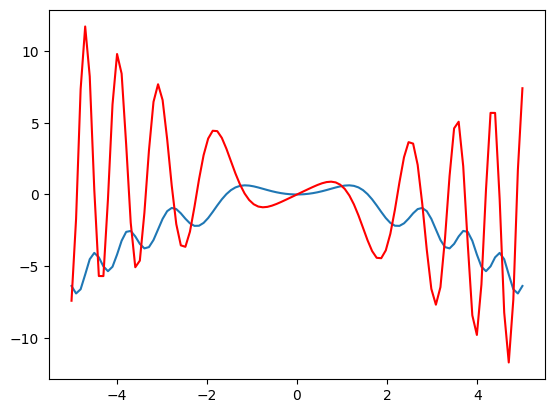

In [27]:
### EXERCISE ###

x = tf.linspace(-5,5,100)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.math.sin(x**2) - x**2/ 4
grad = tape.gradient(y,x)

import matplotlib.pyplot as plt

plt.plot(x,tf.math.sin(x**2) - x**2/ 4)
plt.plot(x,grad, "r")
plt.show()

In [28]:
# Load the Fashion-MNIST dataset

#this would retun the test sets too but we dont want them
(x_train, y_train),_ = tf.keras.datasets.fashion_mnist.load_data()



In [29]:
# Get the class labels

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

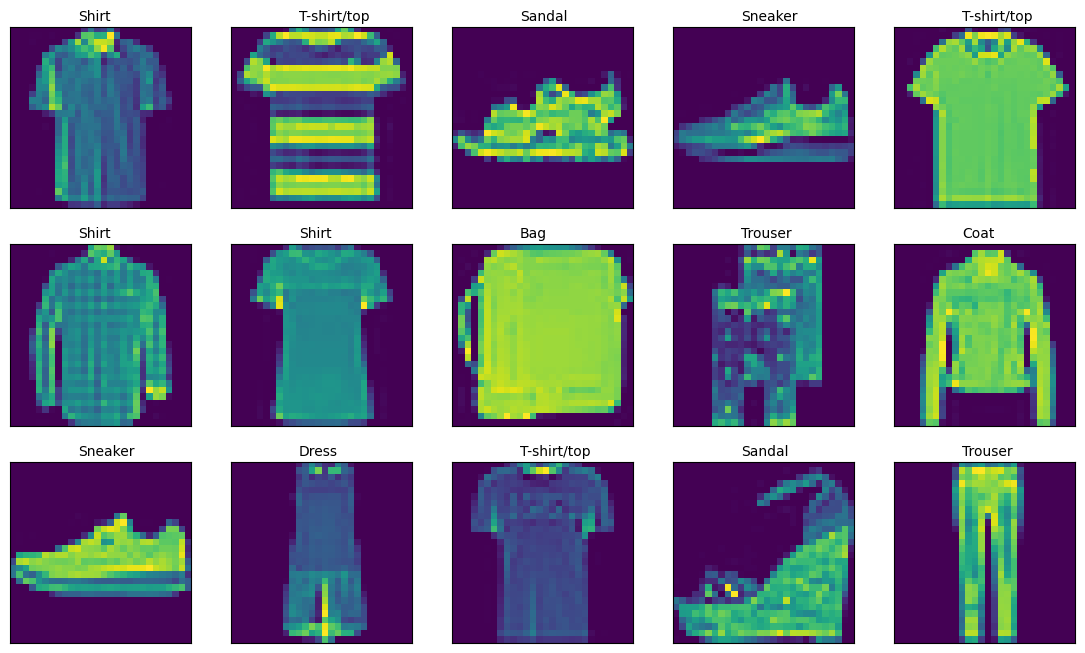

In [30]:
# View a few training data examples

import numpy as np
import matplotlib.pyplot as plt

n_rows, n_cols = 3, 5
random_inx = np.random.choice(x_train.shape[0], n_rows * n_cols, replace=False)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

for n, i in enumerate(random_inx):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(x_train[i])
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].text(10., -1.5, f'{classes[y_train[i]]}')
plt.show()

In [31]:
# Build the model
from keras.layers import Flatten

def get_model():
    model = Sequential([
        #flatten first
        Flatten(input_shape = (28,28)),
        Dense(64,activation = "relu"),
        Dense(64,activation = "relu"),
        #10 outputs as one for each
        Dense(10)
    ],name = "fashion_mnist_classifier")
    return model

fashion_mnist_model = get_model()


In [32]:
# Print the model summary
fashion_mnist_model.summary()
#we can do this since we specified input shape
fashion_mnist_model(x_train)[0]

Model: "fashion_mnist_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                50240     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 55050 (215.04 KB)
Trainable params: 55050 (215.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([  74.29103 ,   84.19716 ,  153.3986  ,  -86.75282 , -205.84177 ,
        -82.51907 ,   69.10622 ,  247.3767  ,  140.89954 ,   15.906524],
      dtype=float32)>

In [33]:
# Define an optimiser
from keras.optimizers import RMSprop
#this needs to be initialised every time we create the new model
rmsprop = RMSprop(learning_rate = 0.005)


In [34]:
# Define the loss function
from keras.losses import SparseCategoricalCrossentropy
#we tell it to expect logits, it will handle softmax etc
loss_fn = SparseCategoricalCrossentropy(from_logits = True)
#this works as we dont have activation function in final layer

We will also use the `tf.data` module to load the training data into a `tf.data.Dataset` object.

In [35]:
# Load the data into a tf.data.Dataset

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_dataset.element_spec

(TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.uint8, name=None))

In [36]:
# Iterate over the Dataset object, grabbing first 2 
for inputs, labels in train_dataset.take(2):
    print(type(inputs))
    print(type(labels))
    print(inputs.shape)
    print(labels.shape)


<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(28, 28)
()
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(28, 28)
()


`Dataset` objects come with `map` and `filter` methods for data preprocessing on the fly. For example, we can normalise the pixel values to the range $[0, 1]$ with the `map` method:

In [37]:
# Normalise the pixel values

def normalise_pixels(image,label):
    return (image/255, label)

#now map it

train_dataset = train_dataset.map(normalise_pixels)
train_dataset.element_spec

(TensorSpec(shape=(28, 28), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.uint8, name=None))

We could also filter out data examples according to some criterion with the `filter` method. For example, if we wanted to exclude all data examples with label $9$ from the training:

In [38]:
# Filter out all examples with label 9 (ankle boot)
train_dataset = train_dataset.filter(lambda x,y: tf.math.logical_not(tf.equal(y,9)))


In [39]:
# Shuffle the dataset

#larger buffer size is better
train_dataset = train_dataset.shuffle(buffer_size = 1024)

In [40]:
# Batch the dataset into batches of 64
batch_size = 64
train_dataset = train_dataset.batch(batch_size)


In [41]:
# Print the element_spec

#each element now has a batch size
train_dataset.element_spec
#this means that we get an initial index stating which batch it is in


(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.uint8, name=None))

We now have everything to write the custom training loop.

In [42]:
# Build the custom training loop
import time

epochs = 5
start = time.perf_counter()

for e in range(epochs):
    #images will now be a batch of 64 for each "tick"
    for images, labels in train_dataset:
        with tf.GradientTape() as tape:
            logits = fashion_mnist_model(images)
            batch_loss = loss_fn(labels,logits)
        grads = tape.gradient(batch_loss, fashion_mnist_model.trainable_weights)
        #now update the parameters
        rmsprop.apply_gradients(zip(grads,fashion_mnist_model.trainable_weights))
    print(f"End of epoch {e} final loss value: {batch_loss}")
print("End of training, time : {:.4f}".format(time.perf_counter() - start))

End of epoch 0 final loss value: 0.5043100714683533
End of epoch 1 final loss value: 0.3418702781200409
End of epoch 2 final loss value: 0.258108526468277
End of epoch 3 final loss value: 0.2716193199157715
End of epoch 4 final loss value: 0.37665343284606934
End of training, time : 44.8841


In [43]:
# Build a new model and create a new optimizer

#can optimize 

fashion_mnist_model = get_model()
#we then have to re-initialise optimiser
rmsprop = RMSprop(learning_rate = 0.005)



In [1]:
# Optimise the custom training loop by compiling the training step into a graph
#this tells tf to optimize computations in thie function
@tf.function
def train_step(images,labels):
    with tf.GradientTape() as tape:
        logits = fashion_mnist_model(images)
        batch_loss = loss_fn(labels,logits)
    grads = tape.gradient(batch_loss, fashion_mnist_model.trainable_weights)
    #now update the parameters
    rmsprop.apply_gradients(zip(grads,fashion_mnist_model.trainable_weights))
    return batch_loss

epochs = 5
start = time.perf_counter()

#tell tensorflow to optimize the function, by converting into a graph
for e in range(epochs):
    #images will now be a batch of 64 for each "tick"
    for images, labels in train_dataset:
        batch_loss = train_step(images, labels)
    print(f"End of epoch {e} final loss value: {batch_loss}")
print("End of training, time : {:.4f}".format(time.perf_counter() - start))

NameError: name 'tf' is not defined

313/313 [==============================] - 0s 627us/step


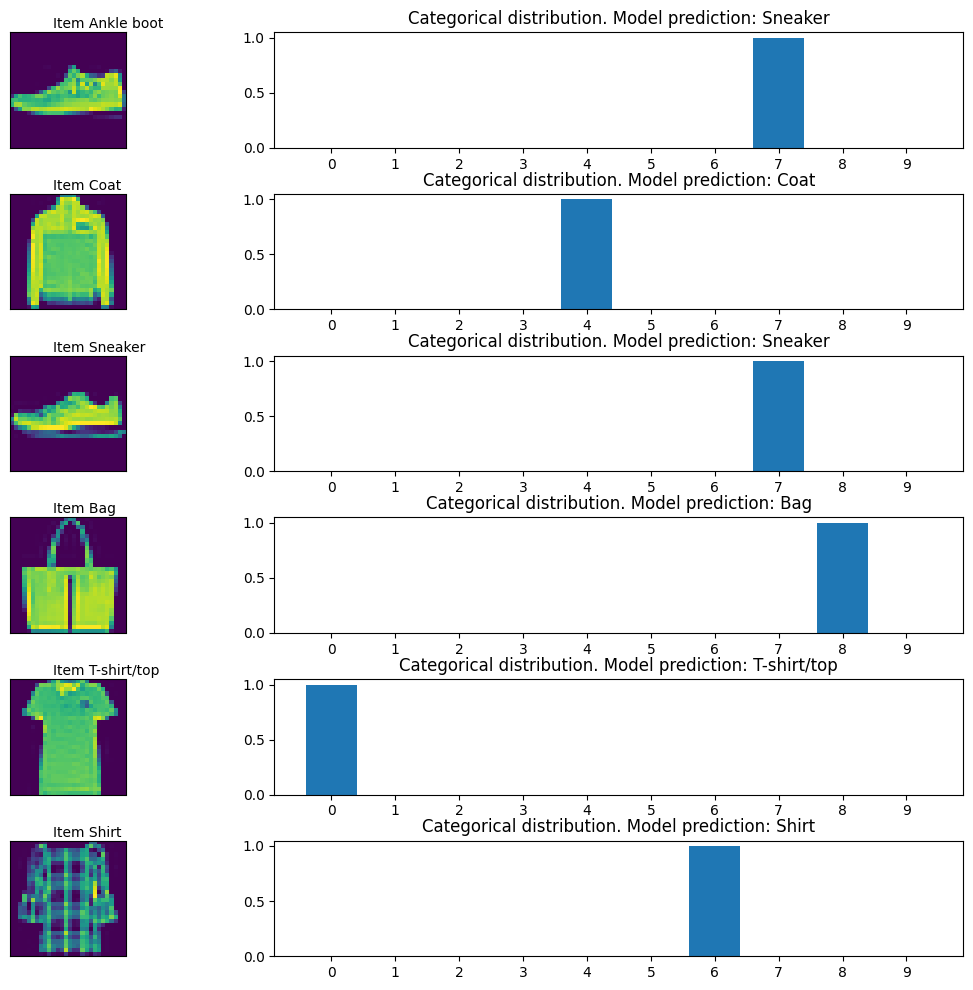

In [45]:
#now test on the data

_,(x_test,y_test) =tf.keras.datasets.fashion_mnist.load_data()
preds = fashion_mnist_model.predict(x_test)
#print(preds)

preds = np.array(tf.nn.softmax(preds))


num_test_images = x_test.shape[0]

random_inx = np.random.choice(num_test_images, 6)
random_preds = preds[random_inx, ...]
random_test_images = x_test[random_inx, ...]
random_test_labels = [classes[i] for i in y_test[random_inx, ...]]

fig, axes = plt.subplots(6, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(random_preds, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Item {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {classes[np.argmax(prediction)]}")
plt.show()

In many cases the data processing pipeline can also be optimised for performance gain, see [here](https://www.tensorflow.org/guide/data_performance) for more information.

<a class="anchor" id="dropout"></a>
## Dropout

Dropout was introduced by [Srivastava et al](#Srivastava14) in 2014 as a regularisation technique for neural networks, that also has the effect of modifying the behaviour of neurons within a network.

The following is taken from the paper abstract:

> Deep neural nets with a large number of parameters are very powerful machine learning systems. However, overfitting is a serious problem in such networks. Large networks are also slow to use, making it difficult to deal with overfitting by combining the predictions of many different large neural nets at test time. Dropout is a technique for addressing this problem. The key idea is to randomly drop units (along with their connections) from the neural network during training. This prevents units from co-adapting too much. During training, dropout samples from an exponential number of different “thinned” networks. At test time, it is easy to approximate the effect of averaging the predictions of all these thinned networks by simply using a single unthinned network that has smaller weights. This significantly reduces overfitting and gives major improvements over other regularization methods.

The method of dropout is to randomly 'zero out' neurons (or equivalently, weight connections) in the network during training according to a Bernoulli mask whose values are independently sampled at every iteration. 

Suppose $\mathbf{W}^{(k)}\in\mathbb{R}^{n_{k+1}\times n_{k}}$ is a weight matrix mapping neurons in layer $k$ to layer $k+1$:

$$
\mathbf{h}^{(k+1)} = \sigma\left( \mathbf{W}^{(k)}\mathbf{h}^{(k)} + \mathbf{b}^{(k)} \right)
$$

We can view dropout as randomly replacing each column of $\mathbf{W}^{(k)}$ with zeros with probability $p_k$. We can write this as applying a Bernoulli mask:

$$
\begin{align}
\mathbf{W}^{(k)} &\leftarrow \mathbf{W}^{(k)} \cdot\text{diag} ([\mathbf{z}_{k, j}]_{j=1}^{n_{k-1}})\\
\mathbf{z}_{k, j} &\sim \text{Bernoulli}(p_k), \qquad k=1,\ldots, L,
\end{align}
$$

with $\mathbf{W}^{(k)}\in\mathbb{R}^{n_{k+1}\times n_{k}}$. The following diagrams illustrate the effect of dropout on a neural network.

<img src="figures/no_dropout.png" alt="MLP with a two hidden layers" style="width: 700px;"/>
<center>Neural network without dropout</center>

<img src="figures/dropout1.png" alt="MLP with a two hidden layers" style="width: 700px;"/>
<center>Neural network with dropout</center>

By randomly dropping out neurons in the network, one obvious effect is that the capacity of the model is reduced, and so there is a regularisation effect. Each randomly sampled Bernoulli mask defines a new 'sub-network' that is smaller than the original. 

In addition, a key motivation of dropout is that it prevents neurons from co-adapting too much. Any neuron in the network is no longer able to depend on any other specific neurons being present, and so each neuron learns features that are more robust, and generalise better.

In the figure below (taken from the [original paper](#Srivastava14)) we see features that are learned on the MNIST dataset for a model trained without dropout (left) and one trained with dropout (right). We see that the dropout model learns features that are much less noisy and more meaningful (it is detecting edges, textures, spots etc.) and help the model to generalise better. The non-dropout model's features suggest a large degree of co-adaptation, where the neurons depend on the specific combination of features in order to make good predictions on the training data.

<img src="figures/dropout_no_dropout.png" alt="Features with and without dropout" style="width: 700px;"/>
<center>Learned features in a neural network trained without dropout (left) and with dropout (right). From Srivastava et al 2014</center>

Typically, dropout is applied only in the training phase. When making predictions, all weight connections  $\mathbf{W}^{(k)}$ are restored, but rescaled by a factor of $p_k$ to take account for the fact that fewer connections were present at training.

However, [Gal & Ghahramani](#Gal16) describe a Bayesian interpretation of dropout, and proposed that dropout is also applied at test time in order to obtain a Bayesian predictive distribution.

In TensorFlow, dropout is available to include in your models as another Keras layer:

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

dropout_model = Sequential([
    Dense(64, activation='sigmoid', input_shape=(784,)),
    Dropout(rate=0.7),
    Dense(64, activation='sigmoid'),
    Dropout(rate=0.7),
    Dense(10, activation='softmax')
])
dropout_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                50240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 55050 (215.04 KB)
Trainable params: 55050 (215.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<a class="anchor" id="batchnorm"></a>
## Batch normalisation

Batch normalisation ([Ioffe & Szegedy 2015](#Ioffe15)) is a widely used method in deep learning. It is used to normalise the distribution of internal activation values in the network, and greatly helps to stabilise learning especially in deep networks. 

The core issue is that of **covariate shift**, which is the change in distribution of input variables to a machine learning model. This can happen in datasets where there is some change in conditions in subsequent data collections, for example over time or location. Whilst the underlying target function might not have changed, the distribution of the input variables does change which means the model could perform poorly in the changed conditions.

The following shows a simple example of a regression function that fails to generalise to new data points whose distribution has shifted from the training data, even though the underlying target function is the same.

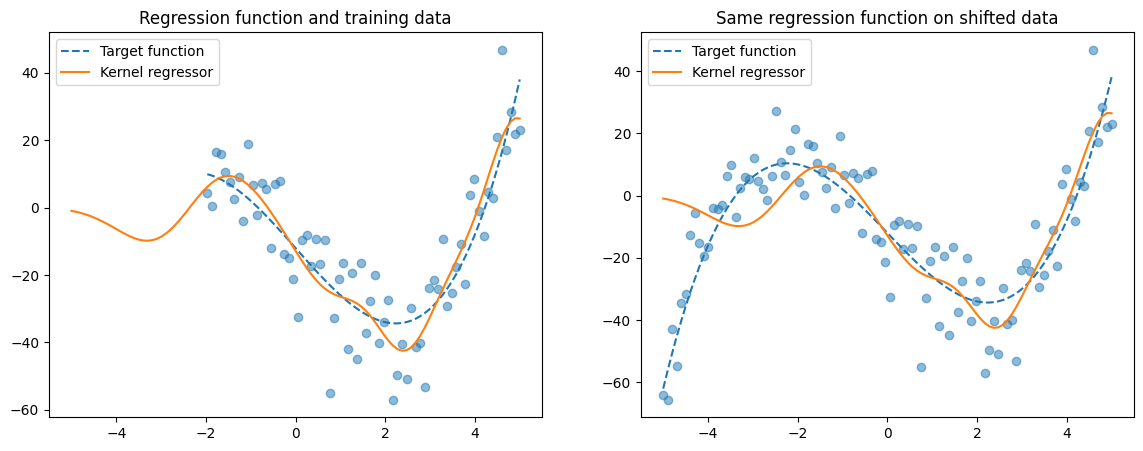

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge

def target(x):
    return x**3 - 15 * x - 12

n_samples = 100
x_train_all = np.linspace(-5, 5, n_samples)[..., np.newaxis]
x_train_sub = x_train_all[30:]
y_train_all = target(x_train_all) + 10 * np.random.randn(n_samples, 1)
y_train_sub = y_train_all[30:]

kernel_regressor_sub = KernelRidge(alpha=1e-2, kernel='rbf', gamma=0.5)
kernel_regressor_sub.fit(x_train_sub, y_train_sub)
mse1 = np.mean((kernel_regressor_sub.predict(x_train_sub) - y_train_sub)**2)

kernel_regressor_all = KernelRidge(alpha=1e-2, kernel='rbf', gamma=0.5)
kernel_regressor_all.fit(x_train_all, y_train_all)

fig = plt.figure(figsize=(14, 5))

fig.add_subplot(1, 2, 1)
plt.plot(x_train_sub, target(x_train_sub), '--')
plt.plot(x_train_all, kernel_regressor_sub.predict(x_train_all))
plt.scatter(x_train_sub, y_train_sub, alpha=0.5)
plt.title("Regression function and training data")
plt.legend(['Target function', 'Kernel regressor'])

fig.add_subplot(1, 2, 2)
plt.plot(x_train_all, target(x_train_all), '--')
plt.plot(x_train_all, kernel_regressor_sub.predict(x_train_all))
plt.scatter(x_train_all, y_train_all, alpha=0.5)
plt.title("Same regression function on shifted data")
plt.legend(['Target function', 'Kernel regressor'])

plt.show()

The same phenomenon can occur during the course of training deep learning models on large datasets, where stochastic minibatches are used in the optimisation procedure. Furthermore, since deep learning models can be viewed as hierarchical feature extractors, we can encounter problems of **internal covariate shift**, where the activation values in hidden layers also undergo changes of distribution due to changes in parameter values and activations in earlier layers. 

<img src="figures/internal_covariate_shift.png" alt="Internal Covariate Shift" style="width: 750px;"/>
<center>Changes in weights and activations earlier in the network cause internal covariate shift in activations in later layers</center>

Batch normalisation reduces the internal covariate shift by normalising the mean and variance of the activation values in a layer. Intuitively speaking, this means that although layer inputs will change over the course of training, they won't change so much that learning becomes very slow or unstable. Batch normalisation also has a slight regularisation effect on the network.

For a layer with $n_k$-dimensional input $\mathbf{h}^{(k)} = (h^{(k)}_1,\ldots,h^{(k)}_{n_k})$, we normalise each input feature

$$
\hat{h}^{(k)}_j = \frac{h^{(k)}_j - \mathbb{E}[h^{(k)}_j]}{\sqrt{\text{Var}[h^{(k)}_j]}}.
$$

In order to maintain full expressive power of the network, we make sure the final transformation can represent the identity:

$$
z^{(k)}_j = \gamma^{(k)}_j \hat{h}^{(k)}_j + \beta^{(k)}_j,
$$

where $\gamma^{(k)}_j$ and $\beta^{(k)}_j$ are learned parameters. Note that setting $\gamma^{(k)}_j = \sqrt{\text{Var}[h^{(k)}_j]}$ and $\beta^{(k)}_j = \mathbb{E}[h^{(k)}_j]$ recovers the original activations. However, now the model can control the mean and variance of activations within the hidden layer $\mathbf{h}^{(k)}$ by tuning the parameters $\gamma^{(k)}_j$ and $\beta^{(k)}_j$. $\mathbf{z}^{(k)}$ then becomes the new input to the next layer in the network.

Statistics $\mathbb{E}[h^{(k)}_j]$ and $\text{Var}[h^{(k)}_j]$ are estimated over each minibatch $\mathcal{D}_m$:

$$
\begin{align}
\mu^{(k)}_{jm} &= \frac{1}{M} \sum_{i=1}^M h^{(k)}_{ij}\\
\left(\sigma^{(k)}_{jm}\right)^2 &= \frac{1}{M} \sum_{i=1}^M (h^{(k)}_{ij} - \mu^{(k)}_{jm})^2\\
\hat{h}^{(k)}_{j} &= \frac{h^{(k)}_{j} - \mu^{(k)}_{jm}}{\sqrt{\left(\sigma^{(k)}_{jm}\right)^2 + \epsilon}}\\
z^{(k)}_{j} &= \gamma^{(k)}_j\hat{h}^{(k)}_{j} + \beta^{(k)}_j =: BN_{\gamma^{(k)}, \beta^{(k)}}\left(h^{(k)}_{j}\right)
\end{align}
$$

where $M = |\mathcal{D}_m|$, and $h^{(k)}_{ij}$ is the activation value for the $j$-th for input $x_i\in\mathcal{D}_m$ in layer $k$.

At training time, the estimates $\mu^{(k)}_{jm}$ and $\sigma^{(k)}_{jm}$ are computed on the minibatch $\mathcal{D}_m$. In practical implementations, a running average of these estimates over the training run is used at test time.

The batch normalisation calculation is fully differentiable, and so gradients can be backpropagated through this calculation as normal. 

The batch normalisation operation is implemented as a layer in TensorFlow. In the following experiment we will recreate the first example from the [original paper](#Ioffe15) on the MNIST dataset.

In [48]:
import tensorflow as tf

In [49]:
# Load the MNIST dataset

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [50]:
# Create Dataset objects

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset.element_spec

(TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.uint8, name=None))

In [51]:
# Normalise pixel values in the Datasets

def normalise_pixels(image, label):
    return (tf.cast(image, tf.float32) / 255., label)

train_dataset = train_dataset.map(normalise_pixels)
test_dataset = test_dataset.map(normalise_pixels)

In [52]:
# Shuffle and batch the dataset

train_dataset = train_dataset.shuffle(1000).batch(60)
test_dataset = test_dataset.batch(60)

We now define an MLP classifier model for the MNIST dataset. The following demonstrates how to build a model using [the functional API](https://www.tensorflow.org/guide/keras/functional).

In [53]:
# Build the classifier model using the functional API

from keras.models import Model
from keras.layers import Flatten, Dense, Input

#with functional API we need to explicitly define input layer
#we dont do this with sequential

inputs = Input(shape = (28,28))
#flatten input. Call the layer on the input
h = Flatten()(inputs)
#then call the dense layer on the flattened input
h = Dense(100,activation = "sigmoid", kernel_initializer=tf.random_normal_initializer)(h)
#add more dense layers
h = Dense(100,activation = "sigmoid", kernel_initializer=tf.random_normal_initializer)(h)
h = Dense(100,activation = "sigmoid", kernel_initializer=tf.random_normal_initializer)(h)
#output
outputs = Dense(10,activation = "softmax")(h)
#so we have input tensor and output tensor

#make model

no_bn_model = Model(inputs = inputs, outputs = outputs)




In [54]:
# Print the model summary

no_bn_model.summary()
#we see now we have explicit input layer

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 100)               78500     
                                                                 
 dense_13 (Dense)            (None, 100)               10100     
                                                                 
 dense_14 (Dense)            (None, 100)               10100     
                                                                 
 dense_15 (Dense)            (None, 10)                1010      
                                                                 
Total params: 99710 (389.49 KB)
Trainable params: 99710 (389.

In [57]:
# Define a loss function, optimiser and metric

#we compile as we did with sequential, using the compile 

no_bn_model.compile(loss = "SparseCategoricalCrossentropy", optimizer="sgd", metrics = ["accuracy"])

In [58]:
# Fit the model

no_bn_history = no_bn_model.fit(train_dataset,epochs = 50, validation_data=test_dataset)

Epoch 1/50


1000/1000 [==============================] - 2s 1ms/step - loss: 2.3034 - accuracy: 0.1097 - val_loss: 2.3010 - val_accuracy: 0.1028
Epoch 2/50
1000/1000 [==============================] - 1s 1ms/step - loss: 2.3017 - accuracy: 0.1103 - val_loss: 2.3002 - val_accuracy: 0.1028
Epoch 3/50
1000/1000 [==============================] - 1s 1ms/step - loss: 2.3010 - accuracy: 0.1142 - val_loss: 2.3001 - val_accuracy: 0.1028
Epoch 4/50
1000/1000 [==============================] - 1s 1ms/step - loss: 2.3003 - accuracy: 0.1135 - val_loss: 2.2985 - val_accuracy: 0.1047
Epoch 5/50
1000/1000 [==============================] - 1s 1ms/step - loss: 2.2995 - accuracy: 0.1154 - val_loss: 2.2981 - val_accuracy: 0.1028
Epoch 6/50
1000/1000 [==============================] - 1s 1ms/step - loss: 2.2985 - accuracy: 0.1173 - val_loss: 2.2971 - val_accuracy: 0.1028
Epoch 7/50
1000/1000 [==============================] - 1s 1ms/step - loss: 2.2973 - accuracy: 0.1205 - val_loss: 2.2956 - val_accurac

In [59]:
# Re-build the model with batch normalisation
from keras.layers import BatchNormalization

#same as above but we have batchnormalisation

inputs = Input(shape = (28,28))
h = Flatten()(inputs)
h = Dense(100,activation = "sigmoid", kernel_initializer=tf.random_normal_initializer)(h)
h = BatchNormalization()(h)
h = Dense(100,activation = "sigmoid", kernel_initializer=tf.random_normal_initializer)(h)
h = BatchNormalization()(h)
h = Dense(100,activation = "sigmoid", kernel_initializer=tf.random_normal_initializer)(h)
h = BatchNormalization()(h)
#output
outputs = Dense(10,activation = "softmax")(h)
#so we have input tensor and output tensor

#make model

bn_model = Model(inputs = inputs, outputs = outputs)


In [60]:
# Compile the model 

bn_model.compile(loss = "SparseCategoricalCrossentropy", optimizer="sgd", metrics = ["accuracy"])

In [61]:
# Fit the model

bn_history = no_bn_model.fit(train_dataset,epochs = 50, validation_data=test_dataset)

Epoch 1/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.4442 - accuracy: 0.8793 - val_loss: 0.4342 - val_accuracy: 0.8796
Epoch 2/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.4357 - accuracy: 0.8814 - val_loss: 0.4263 - val_accuracy: 0.8820
Epoch 3/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.4273 - accuracy: 0.8840 - val_loss: 0.4189 - val_accuracy: 0.8840
Epoch 4/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.4193 - accuracy: 0.8856 - val_loss: 0.4113 - val_accuracy: 0.8859
Epoch 5/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.4115 - accuracy: 0.8879 - val_loss: 0.4044 - val_accuracy: 0.8884
Epoch 6/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.4038 - accuracy: 0.8898 - val_loss: 0.3973 - val_accuracy: 0.8903
Epoch 7/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3965 - accuracy: 0.8909 - val_loss: 0.3905 - val_accuracy:

We will compare the progress of the test accuracy in both models.

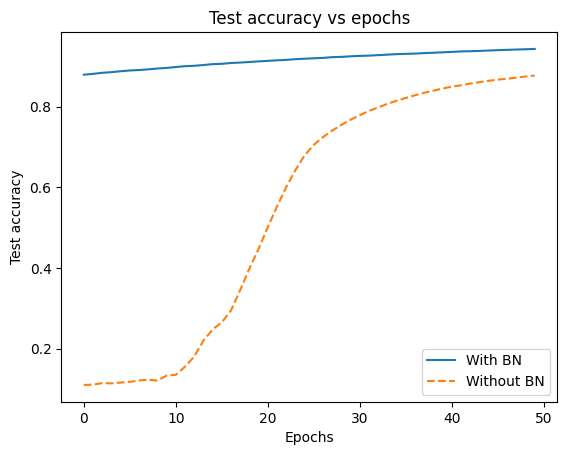

In [62]:
# Plot the test accuracy

import matplotlib.pyplot as plt

plt.plot(bn_history.history['accuracy'])
plt.plot(no_bn_history.history['accuracy'], '--')
plt.legend(['With BN', 'Without BN'])
plt.ylabel("Test accuracy")
plt.xlabel("Epochs")
plt.title("Test accuracy vs epochs")
plt.show()

We see clearly in the above plot that the batch normalisation layers help the model to train faster, and to a higher accuracy.

Batch normalisation reduces internal covariate shift, particularly early on in training. The distribution is more stable, making learning easier.

<a class="anchor" id="references"></a>
### References

<a class="anchor" id="Gal16"></a>
* Gal, Y. & Ghahramani, Z. (2016), "Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning", Proceedings of The 33rd International Conference on Machine Learning, **48**, 1050-1059.
<a class="anchor" id="Ioffe15"></a>
* Ioffe, S. & Szegedy, C., "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift", in *Proceedings of the 32nd International Conference on International Conference on Machine Learning*, **37**, 448–456.
<a class="anchor" id="Rumelhart86b"></a>
* Rumelhart, D. E., Hinton, G., and Williams, R. (1986b), "Learning representations by back-propagating errors", Nature, **323**, 533-536.
<a class="anchor" id="Rumelhart86c"></a>
* Rumelhart, D. E., Hinton, G., and Williams, R. (1986c), "Learning Internal Representations by Error Propagation", in Rumelhart, D. E.; McClelland, J. L. (eds.), Parallel Distributed Processing : Explorations in the Microstructure of Cognition. Volume 1: Foundations, Cambridge, MIT Press.
<a class="anchor" id="Srivastava14"></a>
* Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014), "Dropout: A Simple Way to Prevent Neural Networks from Overfitting", Journal of Machine Learning Research, **15**, 1929-1958.
<a class="anchor" id="Werbos94"></a>
* Werbos, P. J. (1994), "The Roots of Backpropagation: From Ordered Derivatives to Neural Networks and Political Forecasting", New York:, John Wiley & Sons.